In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
np.random.seed(99)

In [3]:
%run ./Logistic_map_data.ipynb
%run ./ESN.ipynb
%run ./Reconstruct.ipynb
%run ./Plot_TDI.ipynb

In [4]:
N_washout = 50
N_train   = 5000
N_tstart  = N_washout
N_test    = N_train

c = 0.3

gamma_list = [3.7, 3.72, 3.78]

strength_list = [1, 0]

In [5]:
dots_colors = ['midnightblue', 'tab:brown']

A1 = np.array([[0,1,0],[0,0,1],[0,0,0]], dtype='float')
A2 = np.array([[0,1,0],[0,0,0],[0,1,0]], dtype='float')

A_S = [A1, A2]

N_data = 100
Time_Series_Data = []

All_TDI_categorized = []
for A in A_S:
    print(A)
    N_x = A.shape[0]

    N_dim   = N_x # dimension of inputs (and outputs)
    N_units = 100 * N_dim #units in the reservoir 
    
    Time_Series_Data.append([])
    
    TDI_categorized = []
    edge_counts = []
    for s in strength_list:
        edge_count = np.sum(np.array(A == np.ones((N_x, N_x)) * s, dtype=int))
        if s == 0:
            edge_count -= N_x
        edge_counts.append(edge_count)
        TDI_categorized.append(np.zeros((N_data, edge_count)))
        
    for n_data in range(N_data):
        X = gen_data(N_x, A, N_tstart+N_test, gamma_list, c=c)
    
        Time_Series_Data[-1].append(X)
        
        # washout
        X_washout = X[:N_washout]
        # training
        X_t = X[N_washout:N_washout+N_train-1]
        Y_t = X[N_washout+1:N_washout+N_train]

        X_test = X[N_tstart:]

        esn = ESN(N_units, N_dim, N_dim, sigma_in = 1)
        esn.train(X_washout, X_t, Y_t)

        N_net, N_rep, N_evo = 15, 50, 2
        TDI_net = np.zeros((N_net, N_x, N_x))
        for net in range(N_net):
            TDI_net[net,:,:] = cal_TDI(esn, X_test, N_x, 1, 0, 0, N_rep, N_washout, N_evo)
        TDI = np.mean(TDI_net, axis=0)
        
        for strength_index in range(len(strength_list)):
            tdi_tmp = []
            xi,xj=np.where(A==strength_list[strength_index])
            for item in zip(xi,xj):
                if item[0] == item[1]:
                    continue
                tdi_tmp.append(TDI[item[0], item[1]])
            TDI_categorized[strength_index][n_data] = np.array(tdi_tmp)
            
    All_TDI_categorized.append(TDI_categorized)
                
    t_stat, p_value = stats.ttest_ind(TDI_categorized[0].flatten(), TDI_categorized[1].flatten())
    print(p_value)
    
    result = [np.array(TDI_categorized[0]), np.array(TDI_categorized[1])]
    correct = np.min(result[0],axis=1) > np.max(result[1],axis=1) if strength_list[0] > strength_list[1] else np.max(result[0],axis=1) < np.min(result[1],axis=1)
    print(f'correct: {np.sum(np.array(correct, dtype=int))} / {N_data}')

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
4.842592700935605e-44
correct: 98 / 100
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
1.5226902176389162e-102
correct: 100 / 100


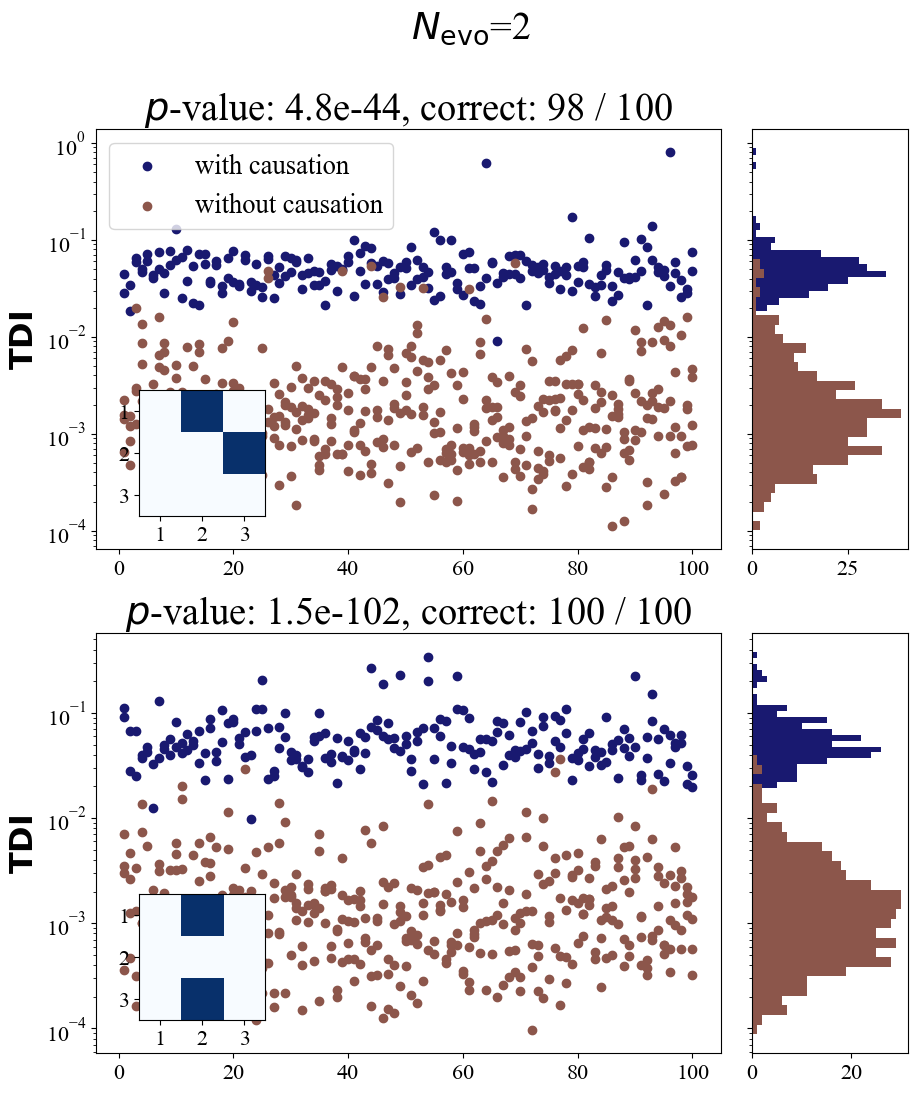

In [8]:
%run ./Plot_TDI.ipynb

plot_dot(A_S, All_TDI_categorized, N_data, strength_list, filename='Logistic_repeat_Nevo2', 
         suptitle=f'$N_\mathrm{{evo}}$={N_evo}')

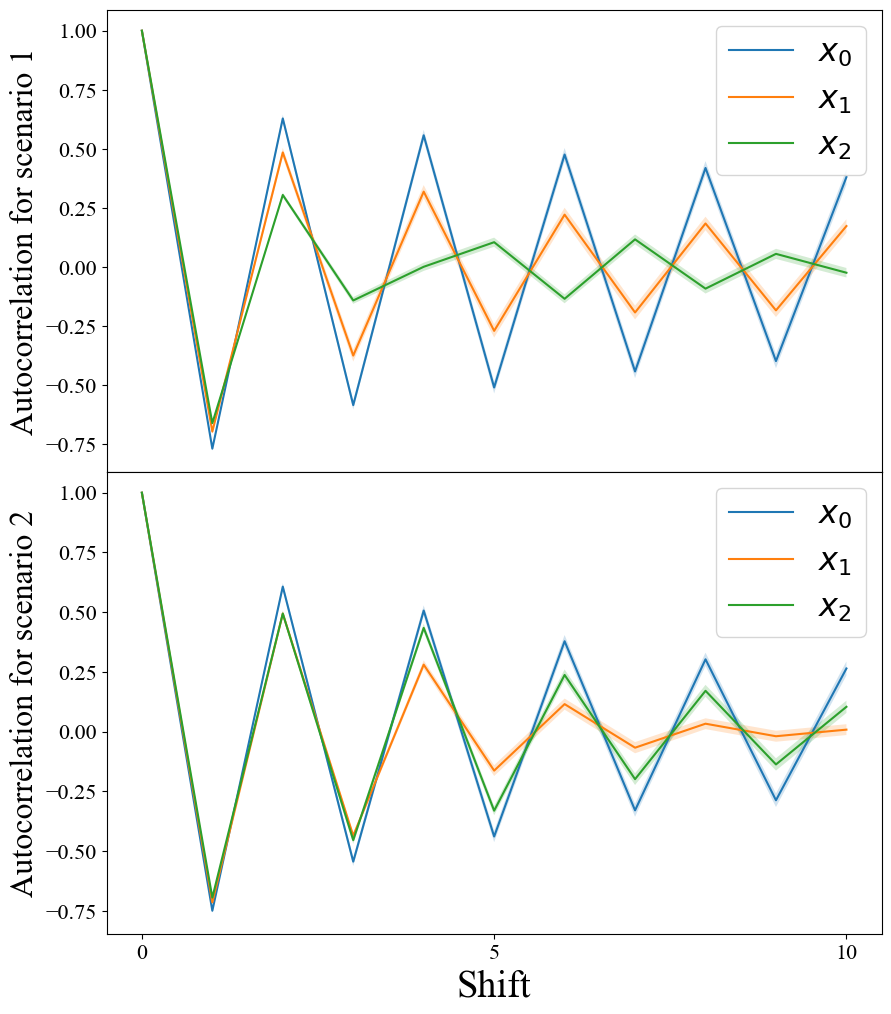

In [7]:
max_shift = 11
autocorrelation_x = []
autocorrelation_y = []
for A in A_S:
    N_x = A.shape[0]
    autocorrelation_x.append(np.zeros((N_x, N_data, max_shift)))
    
for s in range(len(A_S)):
    for data in range(N_data):
        X = Time_Series_Data[s][data]
        N_x = A_S[s].shape[0]
        for node in range(N_x):
            autocorrelation_x[s][node, data, 0]=np.corrcoef(X[:, node], X[:, node])[0,1]
        for shift in np.arange(1,max_shift, 1):
            for node in range(N_x):
                autocorrelation_x[s][node, data, shift]=np.corrcoef(X[:-shift, node], X[shift:, node])[0,1]

fig = plt.figure(figsize=(10, 6*len(A_S)))
axs = fig.subplots(len(A_S), 1, sharex=True)
fig.subplots_adjust(hspace=0)

for s in range(len(A_S)):
    N_x = A_S[s].shape[0]
    
    mean_x = np.mean(autocorrelation_x[s], axis=1)
    std_x = np.std(autocorrelation_x[s], axis=1)
    
    ax = axs[s]
    for node in range(N_x):
        ax.plot(np.arange(max_shift), mean_x[node,:], label=f'$x_{node}$')
        ax.fill_between(np.arange(max_shift), mean_x[node,:]-std_x[node,:], mean_x[node,:]+std_x[node,:], alpha=0.2)

for ax in axs:
    ax.legend(loc='upper right', fontsize='x-large')
    
axs[1].set_xlabel('Shift', fontsize='xx-large')
for s in range(len(A_S)):
    axs[s].set_ylabel(f'Autocorrelation for scenario {s+1}', fontsize='x-large')
    axs[s].set_xticks(np.arange(0,max_shift, 5))
    
plt.show()